# Traffic Signs Classification Project

In cities, public services are being enhanced by using the data collected from sensors and IoT. Traffic systems are capable of processing and analyzing a variety of data types, including images and videos. The systems with the aid of computer vision techniques are able to recognize objects in images and video from traffic cameras, by breaking them into identifying features, and matching them to classes.This can allow a self-driving car to make important decision since one of the main problems for self-driving cars is being able to classify an image of a traffic sign since they are in different shapes and sizes. 

--------- by Dhanusha Lakshmi Yerubandi and Deepanshu Bhasin

In [34]:
# Importing Libraries
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow.keras as keras
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import math

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### 1. Importing Data

Creating labels

In [3]:
data_path = r'gtsrb-german-traffic-sign'
train_path = os.path.join(data_path, 'Train.csv')
meta_path = os.path.join(data_path, 'Meta.csv')
test_path = os.path.join(data_path, 'Test.csv')


labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']


### Loading train and test data

Remapping path in case folders gets converted to lowercase

In [4]:
test_color = '#630f8e'
train_color = '#0f7b8e'
trainDf = pd.read_csv(train_path)
testDf = pd.read_csv(test_path)
metaDf = pd.read_csv(meta_path)

trainDf['Path'] = list(map(lambda x: os.path.join(data_path,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(data_path,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(data_path,x.lower()), metaDf['Path']))

trainDf.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
20298,46,50,5,6,41,45,12,gtsrb-german-traffic-sign\train/12/00012_00064...
7701,47,47,6,6,42,42,4,gtsrb-german-traffic-sign\train/4/00004_00041_...
29068,176,165,16,15,161,151,25,gtsrb-german-traffic-sign\train/25/00025_00019...


## 2. Exploring Data

### 2.1 Checking distribution of different traffic sign classes 

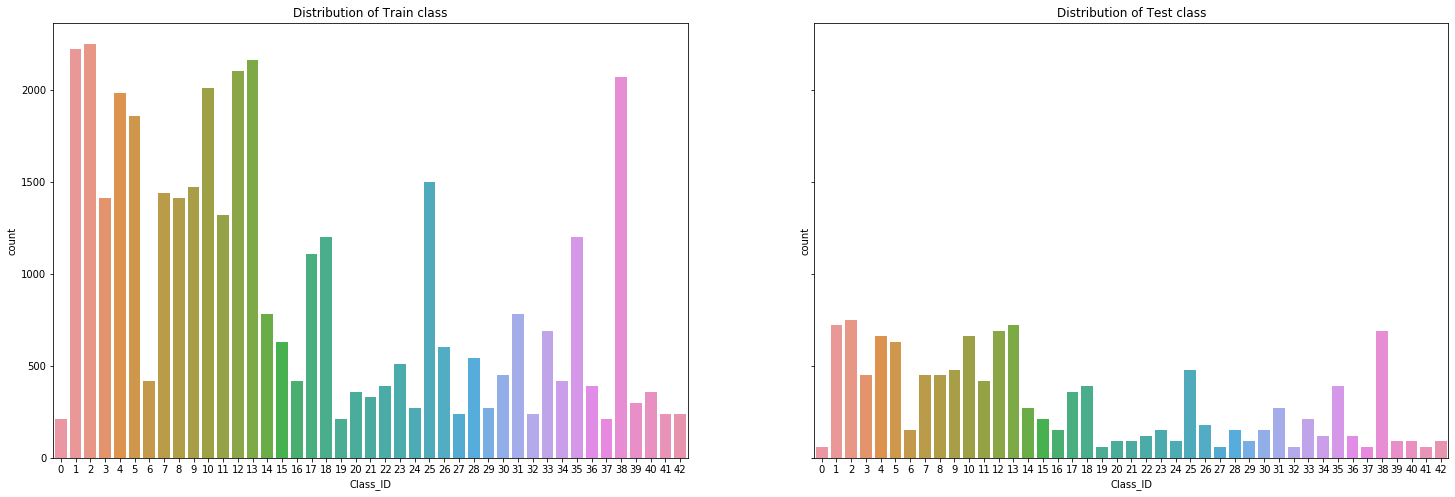

In [5]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 8))
axs[0].set_title('Distribution of Train class')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Distribution of Test class')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class_ID');
axs[1].set_xlabel('Class_ID');

### 2.2 Diffferent Target classes present

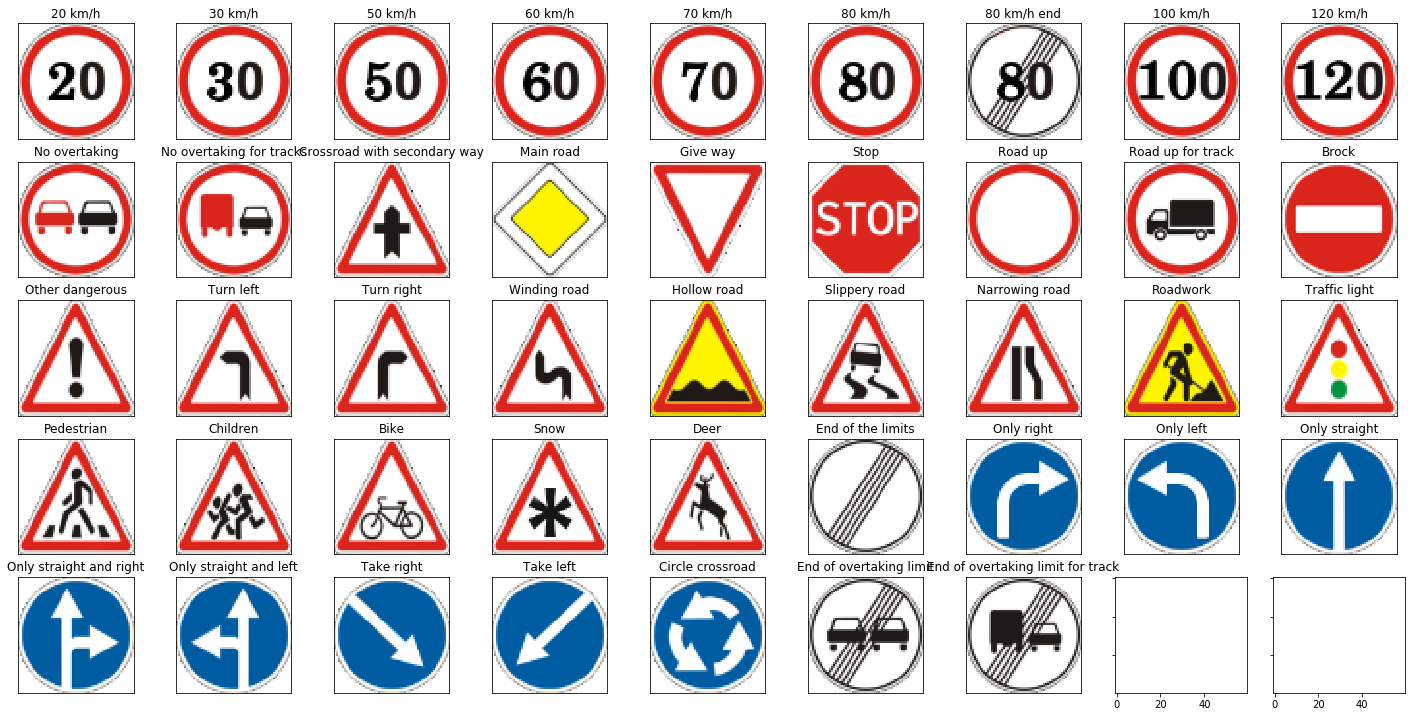

In [6]:
rows = 5
cols = 9
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])
idx = 0

for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### 2.3 Few examples from training set 

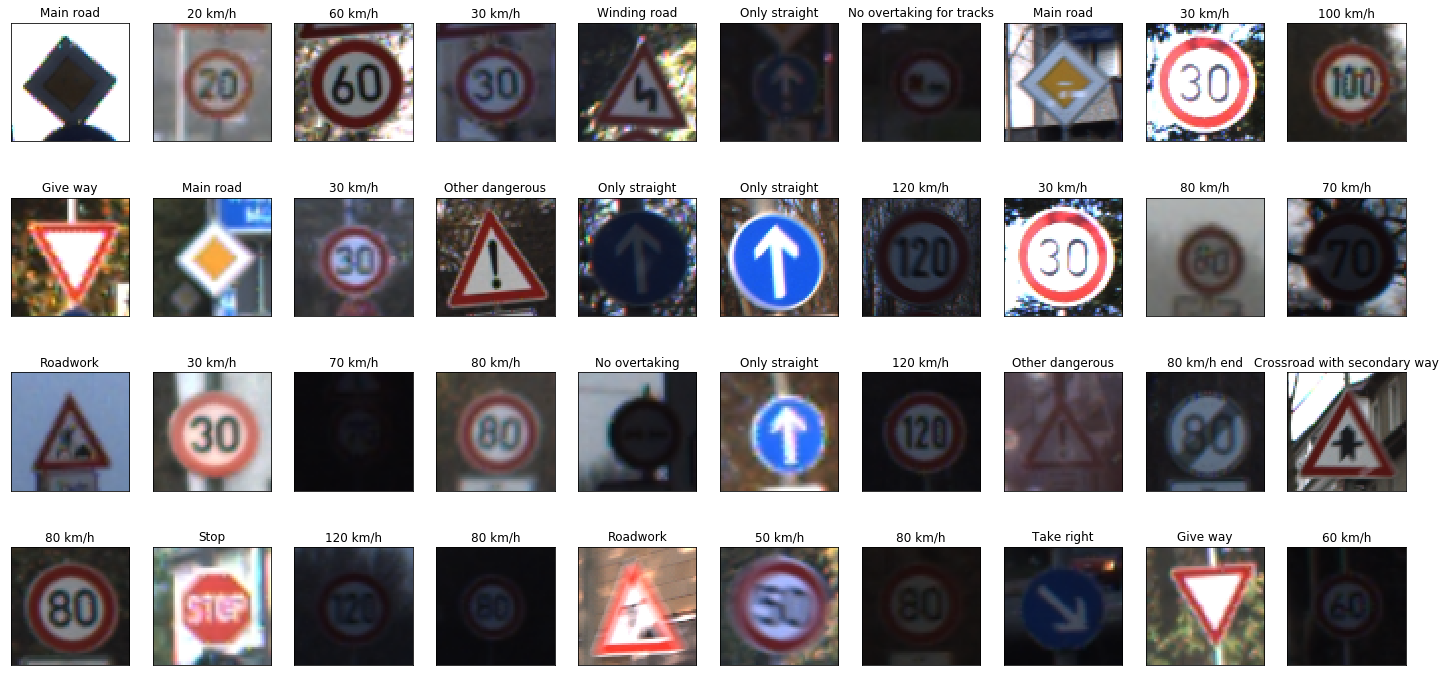

In [7]:
rows = 4
cols = 10
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
trainDf1 = trainDf.sample(rows*cols)


idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img1 = cv2.imread(trainDf1["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (60,60))
        
        axs[i,j].imshow(img1)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(trainDf1["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

## 3. Getting data ready for analysis

### 3.1 Reading images and labels to convert into array

#### Down-Scaling images 
The dataset has images varying from 15x15 to 250x250 pixels. There are street view photos which needs to be scaled down to 30x30 as shown below

In [8]:
data=[]
labels1=[]
for i in range(43):
    path=data_path+r'\Train/{0}/'.format(i)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=Image.open(path+a)
            #image_from_array = Image.fromarray(image, 'RGB')
            size_image = image.resize((30, 30))
            data.append(np.array(size_image))
            labels1.append(i)
        except AttributeError:
            break
        
data=np.array(data)
labels1=np.array(labels1)

#print(labels1)
print(data.shape,labels1.shape)

(39209, 30, 30, 3) (39209,)


### 3.2 Split Image training dataset into train and validation set

In [9]:
Xtrain,Xtest,ytrain,ytest=train_test_split(data,labels1,test_size=0.2,random_state=42)

In [10]:
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


#### One-hot encoding

In [11]:
ytrain=to_categorical(ytrain,43)
ytest=to_categorical(ytest,43)

In [12]:
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367, 43) (7842, 43)


## 4. Building Models with CNN using Keras

### 4.1 Model 1 with different filter dimensions

In [13]:
filters = [3, 5, 9, 13]
model1 = [0] * len(filters)

for i in range(len(model1)):
    model1[i] = tf.keras.Sequential()
    model1[i].add(Conv2D(filters=32, kernel_size=filters[i], padding='same',activation='relu', input_shape=(30,30,3)))
    model1[i].add(MaxPooling2D(pool_size=2))
    model1[i].add(Flatten())
    model1[i].add(Dense(500, activation='relu'))
    model1[i].add(Dense(43, activation='softmax'))

    #Compilation of the model
    model1[i].compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])
    

### Defining Learning Rate Scheduler 

In [18]:
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))

### Training 

In [22]:
history = [0] * len(model1)

for i in range(len(history)):
    history[i] = model1[i].fit(Xtrain, ytrain,
                        batch_size=5, epochs = 5,
                        validation_data = (Xtest, ytest),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f},validation accuracy={3:.5f}'.\
          format(filters[i], epochs, max(history[i].history['accuracy']),max(history[i].history['val_accuracy'])))
    print('training loss={0:.5f},validation loss={1:.5f}'.\
          format(max(history[i].history['loss']),max(history[i].history['val_loss'])))

Model with filters 3x3, epochs=5, training accuracy=0.99053,validation accuracy=0.95167
training loss=0.58733,validation loss=4.56626
Model with filters 5x5, epochs=5, training accuracy=0.89585,validation accuracy=0.84392
training loss=1.06736,validation loss=1.11200
Model with filters 9x9, epochs=5, training accuracy=0.10801,validation accuracy=0.10125
training loss=3.69467,validation loss=3.48317
Model with filters 13x13, epochs=5, training accuracy=0.05570,validation accuracy=0.06325
training loss=3.60444,validation loss=3.48235


### Comparing training and validation accuracy for different filters

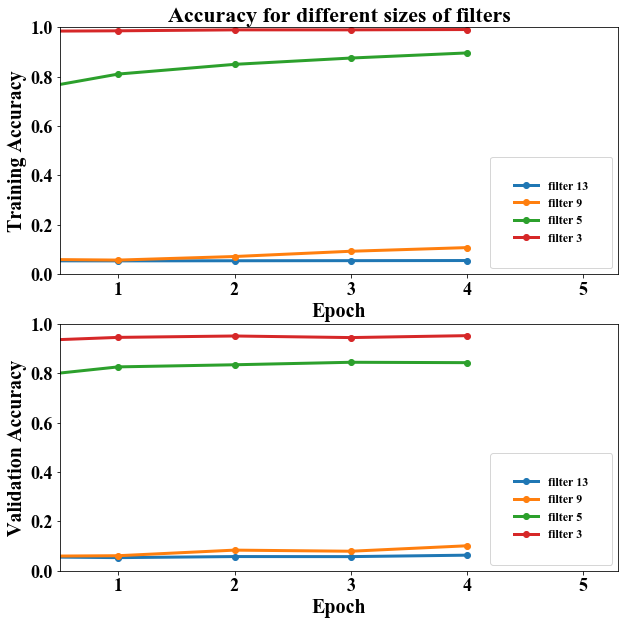

In [56]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

# Figure 4.1.1 - Plotting history of training accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history[3].history['accuracy'], '-o', linewidth=3.0)
plt.plot(history[2].history['accuracy'], '-o', linewidth=3.0)
plt.plot(history[1].history['accuracy'], '-o', linewidth=3.0)
plt.plot(history[0].history['accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.00, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

# Figure 4.1.2 - Plotting history of validation accuracy
plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')
plt.plot(history[3].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(history[2].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(history[1].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(history[0].history['val_accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.00, 1.0)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()

### Checking performance on test set

Comparing predicted class with input class for the images and returned mean value of among all the flattened array elements 

In [48]:
for i in range(len(model1)):
    temp = model1[i].predict(Xtest)
    acc = np.sum(temp == ytest) / np.size(ytest)
    
    print('filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], acc))

filter 3 testing accuracy = 0.97189
filter 5 testing accuracy = 0.28622
filter 9 testing accuracy = 0.00113
filter 13 testing accuracy = 0.00000


### Visualizing filters of the above convolution network

### Image Scaling

In [25]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid

(3, 3, 3, 32)
(32, 3, 3, 3)


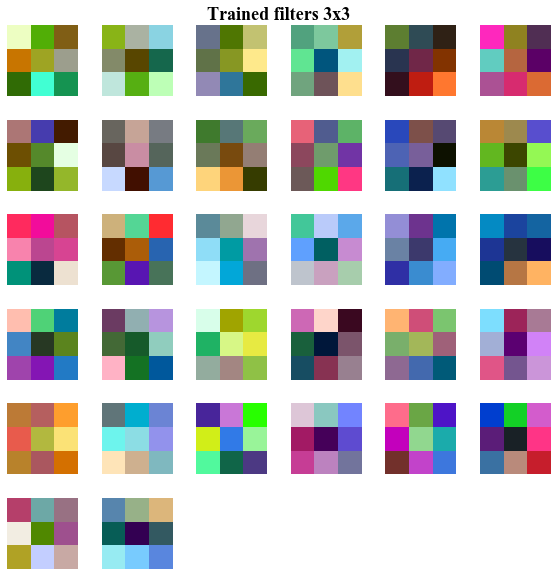

(5, 5, 3, 32)
(32, 5, 5, 3)


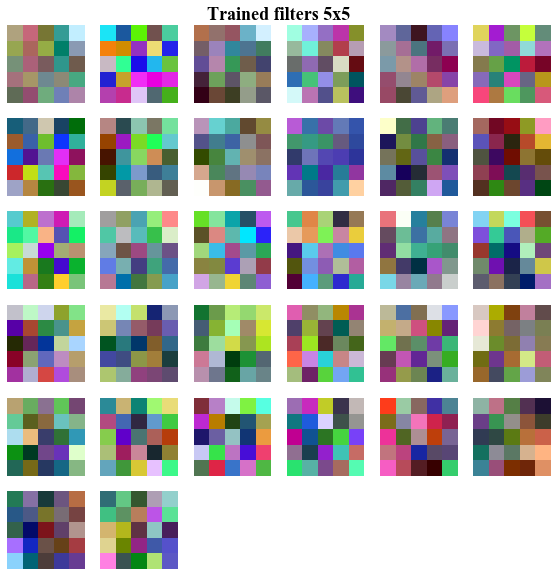

(9, 9, 3, 32)
(32, 9, 9, 3)


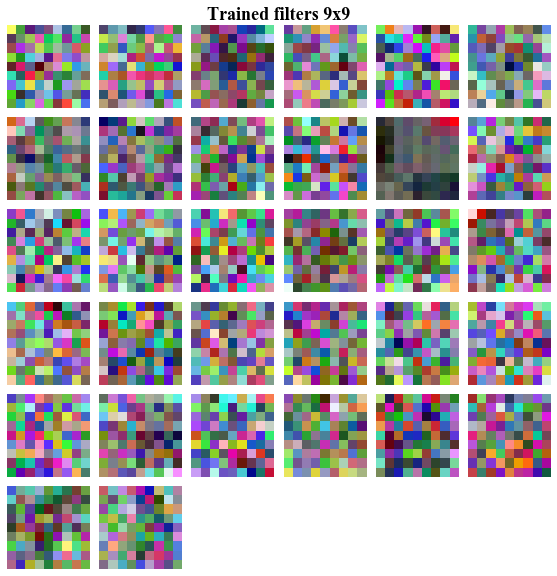

(13, 13, 3, 32)
(32, 13, 13, 3)


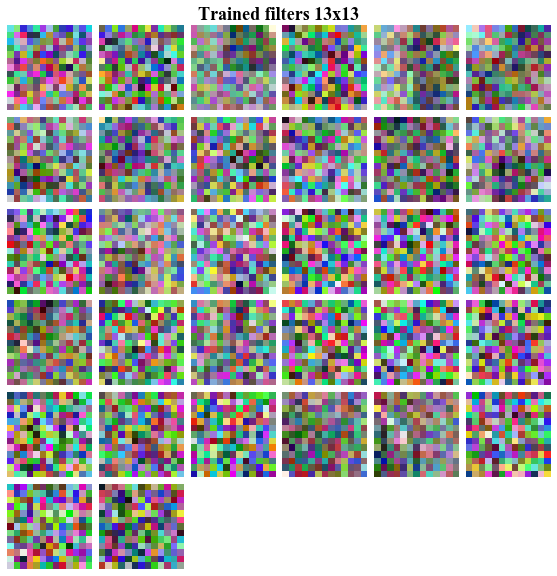

In [26]:
for i in range(len(model1)):
    w = model1[i].get_weights()
    print(w[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape) 

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filters[i]) + 'x' + str(filters[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()
    
    # Saving the plot
    name = 'filters-' + str(filters[i]) + 'x' + str(filters[i]) + '.png'
    fig.savefig(name)
    plt.close()

## 4.2 CNN Model for Image Classification

In [27]:
model = keras.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(30,30,3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compiling of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

### Training and validating 

First, we tried with 32 batch size but the model performance got better with 64 batch size

In [28]:
#using ten epochs for the training and saving the accuracy for each epoch
epochs = 20
history1 = model.fit(Xtrain, ytrain, batch_size=64, epochs=epochs,validation_data=(Xtest, ytest),callbacks=[annealer])

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 55s 2ms/sample - loss: 3.7279 - accuracy: 0.2375 - val_loss: 1.5645 - val_accuracy: 0.5922
Epoch 2/20
31367/31367 [==============================] - 56s 2ms/sample - loss: 1.5751 - accuracy: 0.5630 - val_loss: 0.7094 - val_accuracy: 0.8604
Epoch 3/20
31367/31367 [==============================] - 57s 2ms/sample - loss: 0.8871 - accuracy: 0.7410 - val_loss: 0.3242 - val_accuracy: 0.9304
Epoch 4/20
31367/31367 [==============================] - 62s 2ms/sample - loss: 0.5627 - accuracy: 0.8338 - val_loss: 0.2117 - val_accuracy: 0.9612
Epoch 5/20
31367/31367 [==============================] - 66s 2ms/sample - loss: 0.4044 - accuracy: 0.8813 - val_loss: 0.1162 - val_accuracy: 0.9754
Epoch 6/20
31367/31367 [==============================] - 51s 2ms/sample - loss: 0.3066 - accuracy: 0.9107 - val_loss: 0.0953 - val_accuracy: 0.9790
Epoch 7/20
31367/31367 [==============================] -

In [29]:
_,train_acc=model.evaluate(Xtrain,ytrain,verbose=0)
_,test_acc=model.evaluate(Xtest,ytest,verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.999, Test: 0.995


### Plots to show accuracy and loss

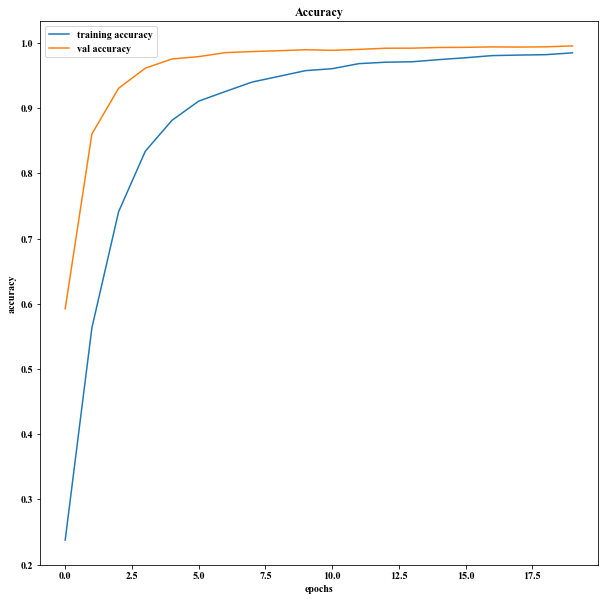

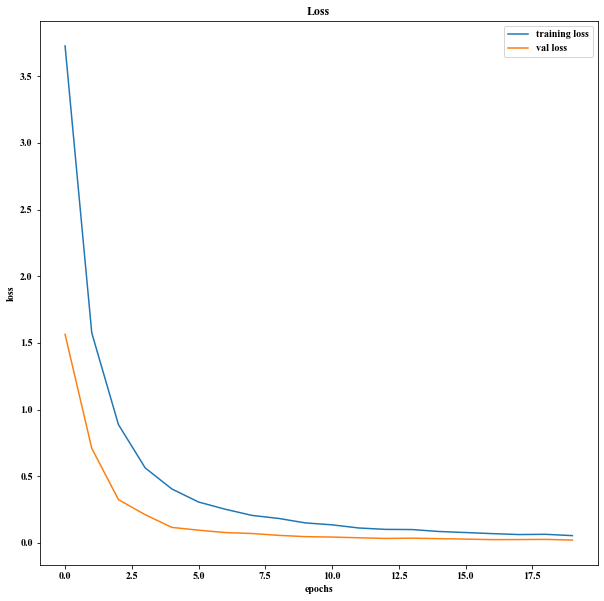

In [57]:
#Figure 4.2.1 - Plot to show changing accuracy with epochs
fig1=plt.figure(0)
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
fig1.savefig('Model_accuracy.png')

#Figure 4.2.2 - Plot to show changing loss with epochs
fig2=plt.figure(1)
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
fig2.savefig('Model_loss.png')

## Testing with test dataset

There is a test.csv file which contains the details related to image path and their respective class labels. 
*Extracting image path and labels using Pandas
*Rescaling images to 30x30 pixels

In [31]:
y_test = testDf
imges=y_test["Path"].values
labels2=y_test["ClassId"].values
#print(labels2.shape)
data2=[]

for i in imges:
    image=Image.open(i)
    #image_from_array = Image.fromarray(image, 'RGB')
    size_image = image.resize((30, 30))
    data2.append(np.array(size_image))

X_test=np.array(data2)

#### Predicting on test data

In [32]:
pred_classes = model.predict_classes(X_test)

In [40]:
# accuracy
print('Accuracy=',accuracy_score(labels2, pred_classes))

Accuracy= 0.9749802058590658


In [41]:
label_name=[labels2[i] for i in range(43)]
print(classification_report(labels2,pred_classes,label_name))

              precision    recall  f1-score   support

          16       1.00      1.00      1.00       150
           1       0.99      1.00      0.99       720
          38       0.99      0.99      0.99       690
          33       0.99      1.00      0.99       210
          11       0.95      0.99      0.97       420
          38       0.99      0.99      0.99       690
          18       0.99      0.92      0.95       390
          12       0.99      0.97      0.98       690
          25       0.97      0.96      0.97       480
          35       1.00      1.00      1.00       390
          12       0.99      0.97      0.98       690
           7       0.98      0.95      0.96       450
          23       0.94      0.98      0.96       150
           7       0.98      0.95      0.96       450
           4       1.00      0.98      0.99       660
           9       0.96      0.99      0.98       480
          21       0.95      0.90      0.93        90
          20       0.87    

Confusion matrix, without normalization


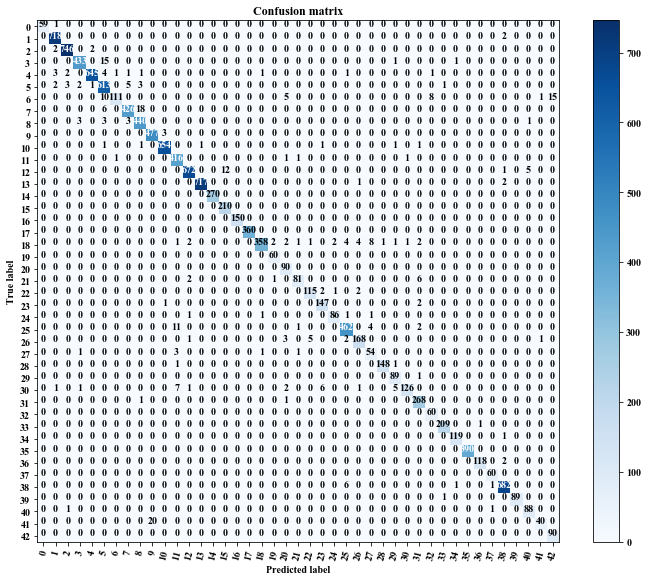

In [42]:
# Figure 4.2.3 - Confussion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(43)
cm = confusion_matrix(labels2,pred_classes)
#print(confMat)

plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

### Classwise Accuracy

In [52]:
class_wise_acc = cm.diagonal()/cm.sum(axis=1) * 100 
class_acc = pd.DataFrame({'Class_Label':[class_names[i] for i in range(43)], 'Accuracy': class_wise_acc.tolist()}, 
                         columns = ['Class_Label', 'Accuracy'])
class_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='orange')

Class_Label,Accuracy
0,98.33
1,99.72
2,99.47
3,96.22
4,97.73
5,97.30
6,74.00
7,94.67
8,97.78
9,99.38


## 5. Traffic Sign Image Classification Prediction Example

     Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
189     40      40       6       6      35      35        8   

                                         Path  
189  gtsrb-german-traffic-sign\test/00189.png  


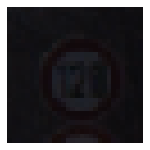

(1, 43)
ClassId: 8
Label: 120 km/h


In [59]:
# Preparing image for test dataset
x_input = X_test[189:190]
#print(x_input.shape)
y_input = y_test[189:190]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores.shape) 

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])